In [2]:
import pandas as pd
import numpy as np

import lyricsgenius as genius


import json
from pandas.io.json import json_normalize




import PIL.Image
from pylab import *
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


In [ ]:
import spacy
import en_core_web_sm

In [ ]:
from textgenrnn import textgenrnn

In [ ]:
from tqdm import tqdm, tqdm_notebook

# using tqdm to get a progress bar on long-loading processes
tqdm.pandas(tqdm_notebook)



In [ ]:

api = genius.Genius('XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX')
artist = api.search_artist('willie-nelson')
lyrics = artist.save_lyrics()

In [ ]:
# save pull as json and convert to df

with open('Lyrics_WillieNelson.json') as json_data:
    data = json.load(json_data)

df = pd.DataFrame(data['songs'])



In [ ]:
# save/load to csv


# df.to_csv('willienelson_songs.csv')

df = pd.read_csv('willienelson_songs.csv')
df.drop('Unnamed: 0', inplace=True, axis=1)

In [ ]:
df.columns

In [ ]:
df.head()

In [ ]:
# get rid of live songs


df = df[~df.title.str.contains("Live")]

In [ ]:
df = df.rename(columns={'lyrics': 'Lyrics', 'title': 'Song', 'album':'Album'})

In [ ]:
df['Album'][0]

In [ ]:
df['Lyrics']

In [ ]:

def preprocessing_songs(df):

  df['Lyric Line'] = df['Lyrics'].apply(lambda x: x.split('\n'))
  df = df.set_index(['Song', 'Album'])['Lyric Line'].apply(pd.Series).stack().reset_index().drop('level_2',1)
  df.rename(columns={0:'Lyric Line'}, inplace=True)

  print('Removing quotes from song...')
  df['Song'] = df['Song'].apply(lambda x: remove_song_quotes(x))  

  print('Counting the number of distinct lines in the lyrics.')
  df['Number Lines'] = df['Lyric Line'].apply(lambda x: number_lines(x))

  print('Counting the number of words in each song.')
  df['Number Words'] = df['Lyric Line'].apply(lambda x: number_words(x))

  print('Calculating the average number of words in each line.')
  df['Average Words Per Line'] = df.apply(lambda row: words_per_line(row['Number Lines'], row['Number Words']), axis=1)

  print('Counting the number of apostrophes in each song.')
  df['Number Apostrophes'] = df['Lyric Line'].apply(lambda x: apostrophe_count(x))

  print('Calculating the average number of words in each line.')
  df['Average Words Per Apostrophe'] = df.apply(lambda row: words_per_apostrophe(row['Number Words'], row['Number Apostrophes']), axis=1)

  print('Cleaning lyrics...')
  df['Cleaned Lyrics'] = clean_text(df, 'Lyric Line')

  return df

In [ ]:
def pre_processing_songs_nlp(df):
  print('Extracting NLP features...')
  df['NLP Features'] = df['Cleaned Lyrics'].progress_apply(lambda x: nlp_pipeline(x))

  df = df.dropna()

  df['Tokens'] = df['NLP Features'].apply(lambda x: x['tokens'])

  df['Lemmas'] = df['NLP Features'].apply(lambda x: x['lemmas'])

  df['Lemmas Text'] = df['Lemmas'].apply(lambda x: ' '.join(x))

  df['Album'] = df['Album'].str.replace(r"\n", " ")
  
  # Replace two spaces with one space
  df['Album'] = df['Album'].str.replace(r"  ", " ")

  df = df.reset_index(drop=True)

  return df

In [ ]:
def nlp_features(df):
  # Create dataframe of syntactic dependency relation counts 'dep'
    df_dep = df['NLP Features'].progress_apply(lambda x: nlp_dict_to_df(x, 'dep_counter'))
    df_dep = df_dep.fillna(value = 0)

    # Create dataframe of coarse-grained parts-of-speech counts 'pos'
    df_pos = df['NLP Features'].progress_apply(lambda x: nlp_dict_to_df(x, 'pos_counter'))
    df_pos = df_pos.fillna(value = 0)

    # Create dataframe of stop word counts 'stop'
    df_stop = df['NLP Features'].progress_apply(lambda x: nlp_dict_to_df(x, 'stop_counter'))
    df_stop = df_stop.fillna(value = 0)

    # Create dataframe of fine-grained parts-of-speech counts 'tag'
    df_tag = df['NLP Features'].progress_apply(lambda x: nlp_dict_to_df(x, 'tag_counter'))
    df_tag = df_tag.fillna(value = 0)

    # Combine all NLP dataframes
    df_spacy = pd.concat([df_stop, df_pos, df_tag, df_dep], axis=1)

    df_spacy = df_spacy.reset_index(drop=True)

    return df_spacy

In [ ]:
def remove_song_quotes(song_row):
  # Removes any quotations around songs
  try:
    song_row = re.sub(r'"', '', song_row)
  except:
    pass

  return song_row

In [ ]:
def number_lines(lyrics_row):
  # Counts the number of distinct lines in the lyrics
  try:
    number_lines = lyrics_row.count('\n') + 1
    return number_lines
  except:
    return 0

In [ ]:
def number_words(lyrics_row):
  # Counts the number of words in each song
  try:
    list_of_words = lyrics_row.split()
    number_words = len(list_of_words)
    return number_words
  except:
    return 0

In [ ]:
def words_per_line(number_lines_row, number_words_row):
    # Calculates the average words per line
    
    if number_words_row == 0:
        # Don't want to return np.nan, return 0
        return 0
    else:
        average_words_per_line = number_words_row / number_lines_row
        return average_words_per_line

In [ ]:
def apostrophe_count(lyrics_row):
    # Counts the number of apostrophes
    
    try:
        number_apostrophes = lyrics_row.count("'")
        return number_apostrophes
    except:
        return 0

In [ ]:
def words_per_apostrophe(number_words_row, number_apostrophes_row):
    # Calculates the average number of words used per apostrophe used
    
    if number_words_row == 0 or number_apostrophes_row == 0:
        # Don't want to return np.nan, return 0
        return 0
    else:
        average_words_per_apostrophe = number_words_row / number_apostrophes_row
        return average_words_per_apostrophe

In [ ]:
def clean_text(df, df_column):
    """
    Removing line breaks, special characters.
    Setting all letters to lowercase -- EXCEPT for pronoun I, kept capitalized.
    """
    
    # Replacing line breaks with one space
    df['Cleaned Lyrics'] = df[df_column].str.replace(r"\n", " ")
    
    # Removing special characters
    df['Cleaned Lyrics'] = df['Cleaned Lyrics'].str.replace(r"[.,?!();:]", "")
    
    # Replace two spaces with one space
    df['Cleaned Lyrics'] = df['Cleaned Lyrics'].str.replace(r"  ", " ")
    
    # Lower-case all words
    df['Cleaned Lyrics'] = df['Cleaned Lyrics'].str.lower()
    
    # Upper-case the pronouns I -- this helps with Spacy Lemmatization
    df['Cleaned Lyrics'] = df['Cleaned Lyrics'].str.replace(r" i i ", " I I ")
    df['Cleaned Lyrics'] = df['Cleaned Lyrics'].str.replace(r" i ", " I ")
    df['Cleaned Lyrics'] = df['Cleaned Lyrics'].str.replace(r" i'", " I'")
    
    return df['Cleaned Lyrics']

In [ ]:
def remove_song_quotes(song_row):
    """
    Removing any quotation marks around songs.
    """      
    
    # Check if the song names have quotes around them (mine did)
    try:
        song_row = re.sub(r'"', '', song_row)
    except:
        pass
    
    return song_row

In [ ]:

def nlp_pipeline(text_document):
    """
    Takes in a string and runs it through Spacy's NLP pipeline consisting of a 
    Tokenizer, Tagger, Dependency Parser, Entity Recognizer, Text Categorizer.
    NLP features are then extracted from each Token's Spacy attributes.
    NLP features are then aggregated for the entire text_document and returned in a dictionary.
    
    Inputs:
        text_document (str): Text data. In this case it is lyrics.
    
    Output:
        dict: Aggregated NLP features.
    """
    
    # Create Spacy NLP pipeline
    nlp = en_core_web_sm.load() 
    
    # Check if text is not a string, if so return np.nan
    if type(text_document) != str:
        return np.nan
    
    # Run Spacy NLP pipeline on text_document, creates DOC object filled with tokens
    doc = nlp(text_document)

    # Tokenization
    tokens = [tok.orth_ for tok in doc]

    # Lemmatization
    lemmas = [tok.lemma_ for tok in doc]

    # Create counter dictionaries to collect counts of NLP features
    pos_counter = {}   # Coarse-grained part-of-speech
    tag_counter = {}   # Fine-grained part-of-speech.
    stop_counter = {}   # Stop word or not
    dep_counter = {}   # Syntactic dependency relation

    # Loop through each Token object contained in Doc object
    for token in doc:

        # Add token 'POS' to dictionary
        pos = "pos_" + token.pos_
        if pos in pos_counter.keys():
            pos_counter[pos] += 1
        else:
            pos_counter[pos] = 1

        # Add token 'TAG' to dictionary
        tag = "tag_" + token.tag_
        if tag in tag_counter.keys():
            tag_counter[tag] += 1
        else:
            tag_counter[tag] = 1

        # Add token 'STOP' to dictionary
        stop = "stop_" + str(token.is_stop)
        if stop in stop_counter.keys():
            stop_counter[stop] += 1
        else:
            stop_counter[stop] = 1

        # Add token 'DEP' to dictionary
        dep = "dep_" + token.dep_
        if dep in dep_counter.keys():
            dep_counter[dep] += 1
        else:
            dep_counter[dep] = 1

    # Combine NLP features into one dictionary
    nlp_dictionary = {'pos_counter' : pos_counter,
                      'tag_counter' : tag_counter,
                      'stop_counter' : stop_counter,
                      'dep_counter' : dep_counter,
                      'tokens' : tokens,
                      'lemmas' : lemmas}
    
    return nlp_dictionary

In [ ]:
def nlp_dict_to_df(nlp_features, feature):
    """
    Take in nlp_features dictionary, outputs a pd.Series object 
    containing the NLP features.
    
    Inputs:
        nlp_features (dict): Aggregated NLP features.
    
    Outputs:
        nlp_series (pd.Series): NLP features for each song obtained using Spacy.
    """
    
    # Dep dictionary
    nlp_dict = nlp_features[feature]

    # Total number of entries in dep dictionary
    nlp_total = np.sum(list(nlp_dict.values()))

    # Calculate fraction of total for each NLP feature (Normalization)
    nlp_dict_fractions = {k: v / nlp_total for k, v in nlp_dict.items()}

    # Turn into a pandas Series to return
    nlp_series = pd.Series(nlp_dict_fractions)
    
    return nlp_series

In [ ]:
clean_df = preprocessing_songs(df)

In [ ]:
clean_df.drop('Album', inplace=True, axis=1)

clean_df.head()

In [ ]:
clean_df['Number Words'].sum()

In [ ]:
new_df = pre_processing_songs_nlp(clean_df)

In [ ]:
# try to get rid of one lines like [Verse 1] etc...


new_df.drop(new_df[new_df['Number Words'] <= 1].index, inplace=True)

In [ ]:
data = pd.read_csv('willienelson_clean_nlp.csv')

In [ ]:

lyrics_data = data[['Lyric Line', 'Song', 'Cleaned Lyrics']]
lyrics_data = lyrics_data.set_index('Lyric Line')

# We will read in all of the cleaned lyrics into a single text file for training
with open('lyricsText.txt', 'w', encoding='utf-8') as filehandle:
  for listitem in lyrics_data['Cleaned Lyrics']:
    filehandle.write('%s\n' % listitem)

In [ ]:
spacy_df = nlp_features(new_df)

In [ ]:

model_cfg = {
    'rnn_size': 128,
    'rnn_layers': 4,
    'rnn_bidirectional': True,
    'max_length': 40,
    'max_words': 10000,
    'dim_embeddings': 100,
    'word_level': False,
}

train_cfg = {
    'line_delimited': True,
    'num_epochs': 10, 
    'gen_epochs': 2,
    'batch_size': 1024,
    'train_size': 0.8,
    'dropout': 0.0,
    'max_gen_length': 300,
    'validation': True,
    'is_csv': False
}

text_file = '../input/willienelsonsong/lyricsText.txt'

model_name = '500nds_12Lrs_100epchs_Model'

textgen = textgenrnn(name=model_name)

train_function = textgen.train_from_file if train_cfg['line_delimited'] else textgen.train_from_largetext_file

train_function(
    file_path=text_file,
    new_model=True,
    num_epochs=train_cfg['num_epochs'],
    gen_epochs=train_cfg['gen_epochs'],
    batch_size=train_cfg['batch_size'],
    train_size=train_cfg['train_size'],
    dropout=train_cfg['dropout'],
    max_gen_length=train_cfg['max_gen_length'],
    validation=train_cfg['validation'],
    is_csv=train_cfg['is_csv'],
    rnn_layers=model_cfg['rnn_layers'],
    rnn_size=model_cfg['rnn_size'],
    rnn_bidirectional=model_cfg['rnn_bidirectional'],
    max_length=model_cfg['max_length'],
    dim_embeddings=model_cfg['dim_embeddings'],
    word_level=model_cfg['word_level'])

In [ ]:
print(textgen.model.summary())

In [ ]:
weights_path = '{}_weights.hdf5'.format(model_name)

In [ ]:
vocab_path = '500nds_12Lrs_100epchs_Model_vocab.json'

In [ ]:
config_path = '500nds_12Lrs_100epchs_Model_config.json'

In [ ]:
textgen = textgenrnn(weights_path=weights_path,
                       vocab_path=vocab_path,
                       config_path=config_path)

generated_characters = 300

text = textgen.generate_samples(300)

In [3]:
lyrics = pd.read_csv('lyricsText.txt', header=None)

In [4]:
lyrics

,0
0,cruel cruel world must I go on
1,cruel cruel world I'm moving on
2,i've been living too fast
3,and I've been living too long
4,cruel cruel world I'm gone
...,...
18087,now she's gone and it don't matter anymore
18088,crossing dreams with our lives
18089,it was more than just a woman and a man
18090,it was love without disguise


In [5]:
wordbank = lyrics[0].unique()
wordbank

array(['cruel cruel world must I go on',
       "cruel cruel world I'm moving on", "i've been living too fast",
       ..., 'it was more than just a woman and a man',
       'it was love without disguise',
       'and now my life will never be the same again'], dtype=object)

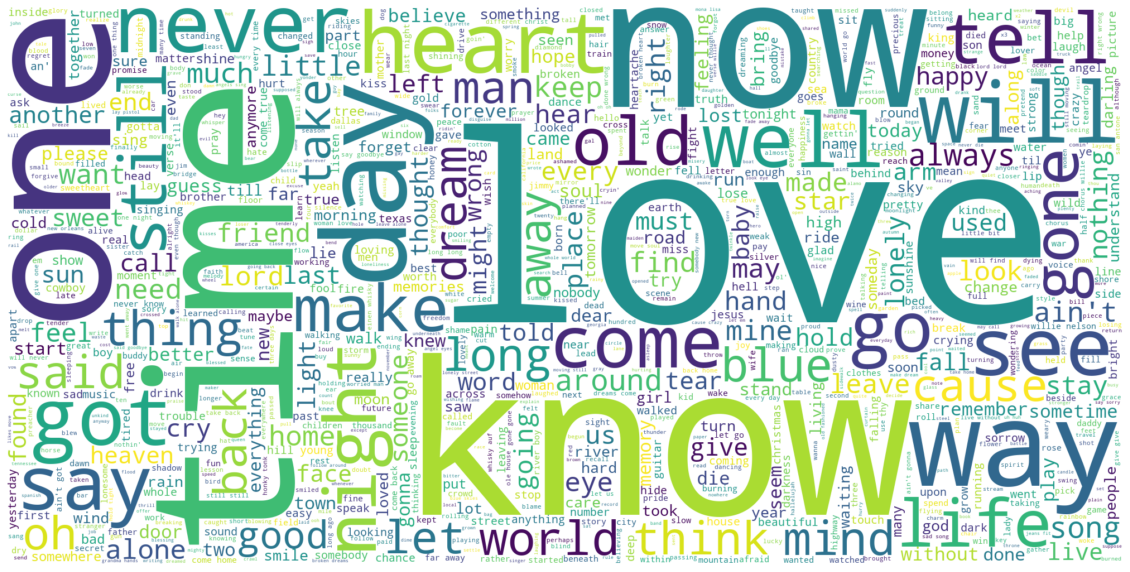

In [6]:
# build a word cloud

stopwords = set(STOPWORDS)

wordcloud = WordCloud(background_color='white', stopwords=stopwords, max_words=1000, width=2000, height=1000).generate(' '.join(wordbank))

# display the word cloud

fig = plt.figure()
fig.set_figwidth(20) # set width
fig.set_figheight(20) # set height

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Image opened and saved!


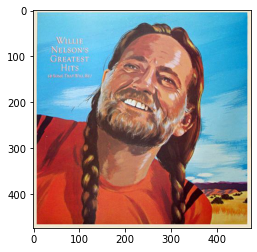

In [7]:
# open image (just make sure it's in your working directory) 

cover = np.array(PIL.Image.open('willie_cover.png'))

imshow(cover)

print('Image opened and saved!')

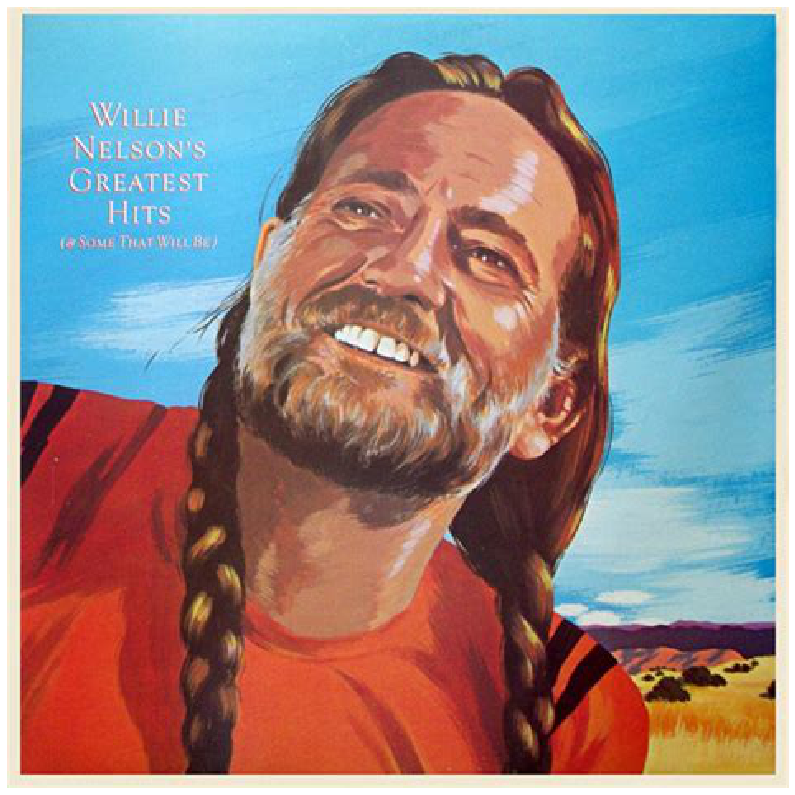

In [8]:
# display mask image

fig = plt.figure()
fig.set_figwidth(14) # set width
fig.set_figheight(18) # set height

plt.imshow(cover, cmap=plt.cm.gray, interpolation='None')
plt.axis('off')
plt.show()

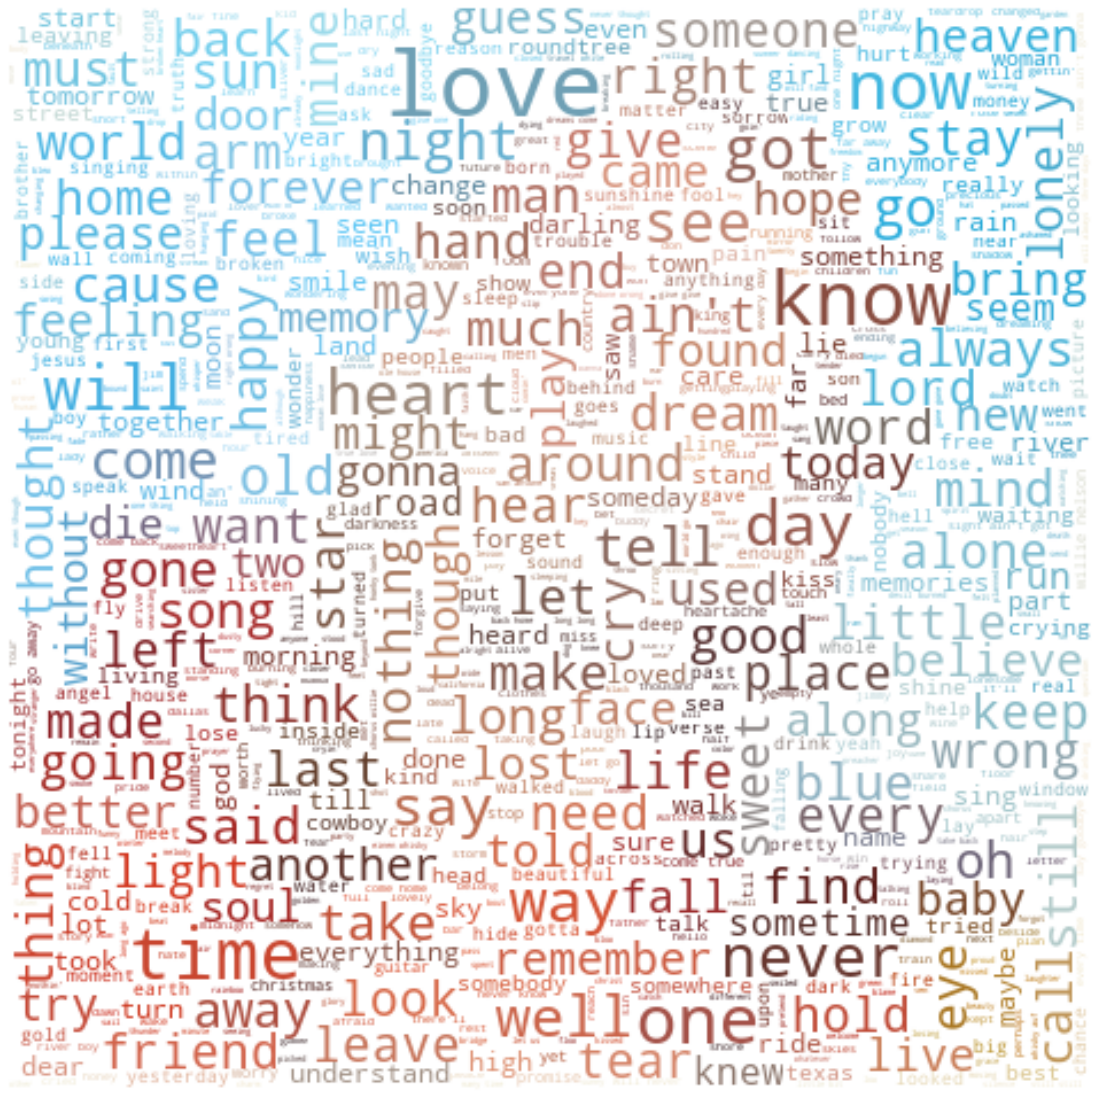

In [9]:

willie_coloring = cover
stopwords = set(STOPWORDS)


wc = WordCloud(background_color="white", max_words=10000, mask=willie_coloring,
               stopwords=stopwords, max_font_size=40, random_state=42)
# generate word cloud
wc.generate(' '.join(wordbank))

# create coloring from image
image_colors = ImageColorGenerator(willie_coloring)

# show
plt.figure(figsize=(20, 20))

# recolor wordcloud and show
# we could also give color_func=image_colors directly in the constructor
plt.imshow(wc.recolor(color_func=image_colors), interpolation="bilinear")

plt.axis('off')

plt.show()

Image opened and saved!


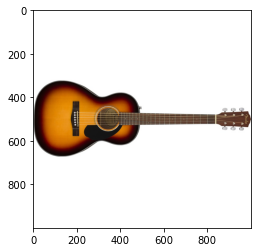

In [10]:
# open image (just make sure it's in your working directory) 

guitar = np.array(PIL.Image.open('guitar_color.png'))

imshow(guitar)

print('Image opened and saved!')

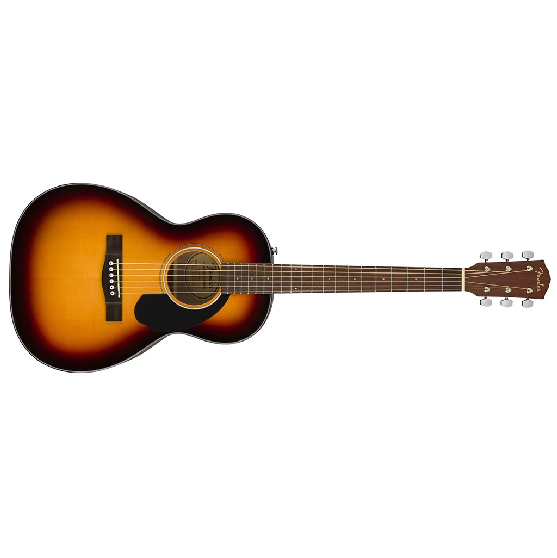

In [11]:
# display mask image

fig = plt.figure()
fig.set_figwidth(10) # set width
fig.set_figheight(10) # set height

plt.imshow(guitar, cmap=plt.cm.gray, interpolation='None')
plt.axis('off')
plt.show()

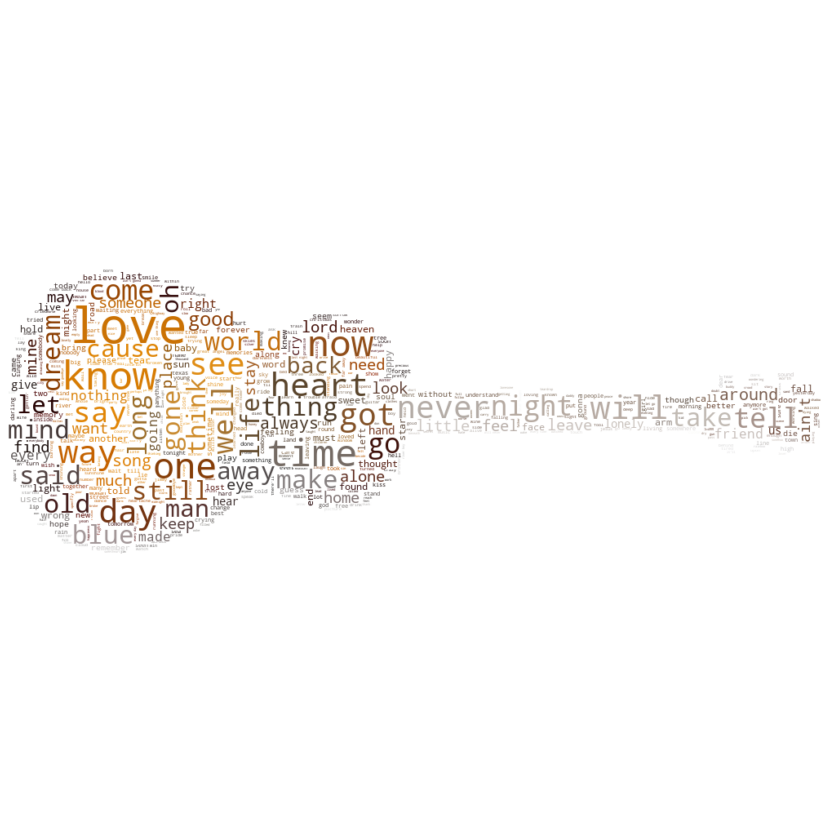

In [12]:
willie_coloring = guitar
stopwords = set(STOPWORDS)


wc = WordCloud(background_color="white", max_words=4000, mask=willie_coloring,
               stopwords=stopwords, max_font_size=60, random_state=42)
# generate word cloud
wc.generate(' '.join(wordbank))

# create coloring from image
image_colors = ImageColorGenerator(willie_coloring)

# show
plt.figure(figsize=(15, 15))

# recolor wordcloud and show
# we could also give color_func=image_colors directly in the constructor
plt.imshow(wc.recolor(color_func=image_colors), interpolation="bilinear")

plt.axis('off')

plt.show()